## The Notebook for Power Dependence Analysis of 2-photon dissociation Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import odr
from processing import ProcessData
from constants import ApproachEnum, MeasureEnum, lifetime_outfile, plot_params, confidence
from pathlib import Path
from scipy.stats import gaussian_kde
%matplotlib inline

### Process power dependence data

In [2]:
task = 'run_8'
process = ProcessData(task, copy_files=False, do_2photon=True, process_y_line_sum=False)

In [3]:
process.run(do_int=True, do_liv=True, plot=True, save_plot=True)

In [4]:
df = pd.read_csv(lifetime_outfile(task, MeasureEnum.live, ApproachEnum.bayesian), sep="    ", engine="python")
df

,wl(nm),mean_lt(s),mle_lt(s),CI_low[lt],CI_high[lt],int(W/m2),int_er,label,file
0,500,448.943874,349.2,291.9,599.4,4.584760e+05,83095.526798,500 p4000 1 230801/02,2023_08_02_00h_00m_00s_dissociation_measurement
1,500,295.010974,245.7,206.7,380.7,6.877804e+05,124263.137158,500 p6000 1 230803,2023_08_03_10h_34m_25s_dissociation_measurement
2,500,236.802421,189.3,158.7,312.0,5.708184e+05,102545.224581,500 p5000 1 230824,2023_08_24_10h_46m_18s_dissociation_measurement
3,500,76.388889,68.7,58.8,93.6,8.398164e+05,154795.733995,500 p7000 1 230825,2023_08_25_10h_46m_41s_dissociation_measurement
4,500,78.895789,71.4,61.2,96.3,1.079203e+06,198292.458809,500 p9000 1 230829,2023_08_29_11h_49m_52s_dissociation_measurement
5,500,254.341321,190.8,159.3,344.4,6.845102e+05,122456.020613,500 p6000 1 230831,2023_08_31_00h_00m_00s_dissociation_measurement
6,500,37.031562,34.8,30.3,43.5,9.941623e+05,182967.087100,500 p8300 1 230901,2023_09_01_10h_11m_43s_dissociation_measurement


In [5]:
x = df["int(W/m2)"].values
dx = df["int_er"].values
y = 1 / df["mle_lt(s)"].values
y_max = 1 / df["CI_low[lt]"].values
y_min = 1 / df["CI_high[lt]"].values
dy = np.array([y - y_min, y_max - y])

### Plot power dependence

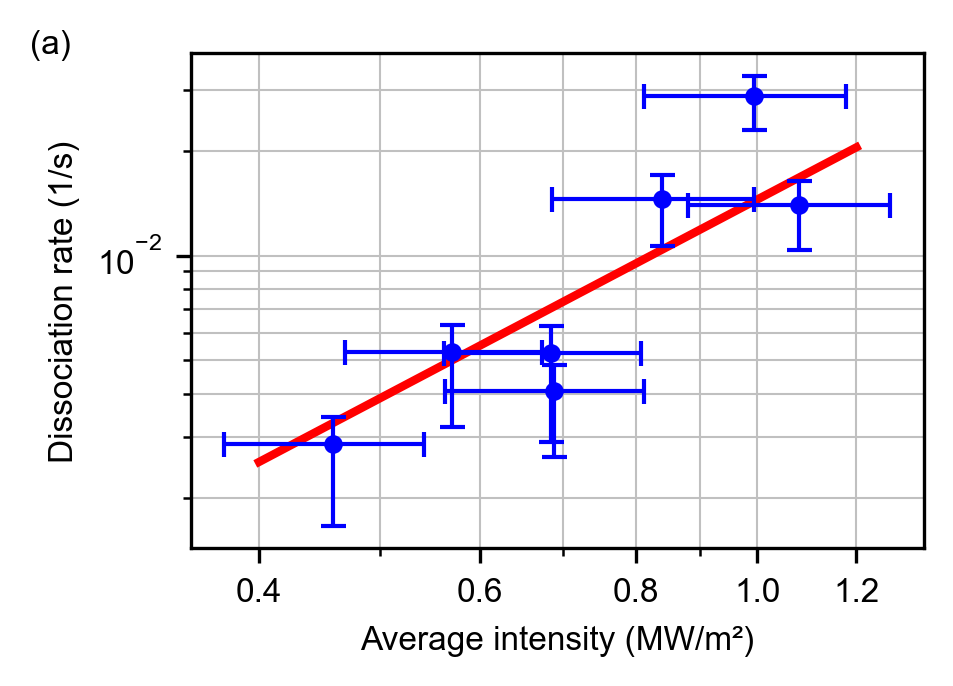

In [19]:
plt.rcParams.update(plot_params)
fig, ax = plt.subplots()
fit_x = np.linspace(0.4, 1.2, 100)
fit_y = 0.0145 * fit_x**1.9  # taken from the fit mentioned below
ax.plot(fit_x, fit_y, color=(1,0,0,1), linewidth=2.0)
# ax.plot(fit_x, fit_y_2, color=(1,0,1,.5), linewidth=2.0)
# ax.plot(fit_x, fit_y_3, color=(1,1,1,.5), linewidth=2.0)
# ax.fill_between(fit_x, fit_y_min, fit_y_max, facecolor=(1,0,0,.2), edgecolor=(1,0,0,.01))
ax.scatter(x*1e-6, y, marker="o", c="b", s=12, zorder=10)
ax.errorbar(x*1e-6, y, xerr=dx*1e-6, yerr=dy, fmt="", ls="none", ecolor="b", elinewidth=1.0, capsize=3.0, capthick=1.0, zorder=10)
ax.set_xlabel(r"Average intensity (MW/m²)")
ax.set_ylabel(r"Dissociation rate (1/s)")
# ax.set_xlabel(r"$I_{\mathrm{avg}}$ (MW/m²)")
# ax.set_ylabel(r"$T_D^{-1}$ (1/s)")
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(np.arange(0.4,1.4,0.2))
ax.set_xticklabels([0.4,0.6,0.8,1.0,1.2])
ax.text(-0.22, 1.0, "(a)", transform=plt.gca().transAxes)
plt.savefig('power_dependence_2photon.eps', format='eps', dpi=300)

### Fitting functions

In [7]:
def linear_func(a, x):
    return a * x

def quad_func(a, x):
    return a * x**2

def cub_func(a, x):
    return a * x**3

def exp_func(beta, x):
    return beta[0] * x**beta[1]

def poly_func(beta, x):
    return beta[0] * x + beta[1] * x**2 + beta[2] * x**3 

### Read in Monte Carlo samples

In [8]:
def samples_file_intensity(measurement):
    return Path().cwd().joinpath(f'samples/samples_intensity/{measurement}_intensity.npy')
def samples_file_lifetime(measurement, meas_type:MeasureEnum):
    return Path().cwd().joinpath(f'samples/samples_lifetime/{measurement}_lifetime_{meas_type.value}.npy')
def samples_array_intensity():
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_intensity(measurement), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T
def samples_array_lifetime(meas_type:MeasureEnum):
    samples_list = []
    for measurement in process.data.datainfo_json.keys():
        with open(samples_file_lifetime(measurement, meas_type), 'rb') as f:
            samples = np.load(f)
            samples_list.append(samples)
    return np.array(samples_list).T

In [9]:
samples_intensity = samples_array_intensity()
print(np.mean(samples_intensity, axis=0))
samples_lifetime = samples_array_lifetime(MeasureEnum.live)
print(np.mean(samples_lifetime, axis=0))


[ 458476.03525923  687780.44895716  570818.39781735  839816.44081345
 1079203.02792322  684510.15218992  994162.27135497]
[448.899387 295.049457 236.794323  76.350033  78.879303 254.396511
  36.997599]


### Fitting each sample to power law

In [10]:
def exp_fit(x_array, y_array):
    data = odr.RealData(x_array, y_array)
    model = odr.Model(exp_func)
    o = odr.ODR(data, model, beta0=[0.017, 2.7])
    out = o.run()
    return out.beta

In [11]:
samples_fit = np.array([exp_fit(samples_intensity[i]*1e-6, 1/samples_lifetime[i]) for i in range(samples_intensity.shape[0])])

### KDE of the fits: coefficient

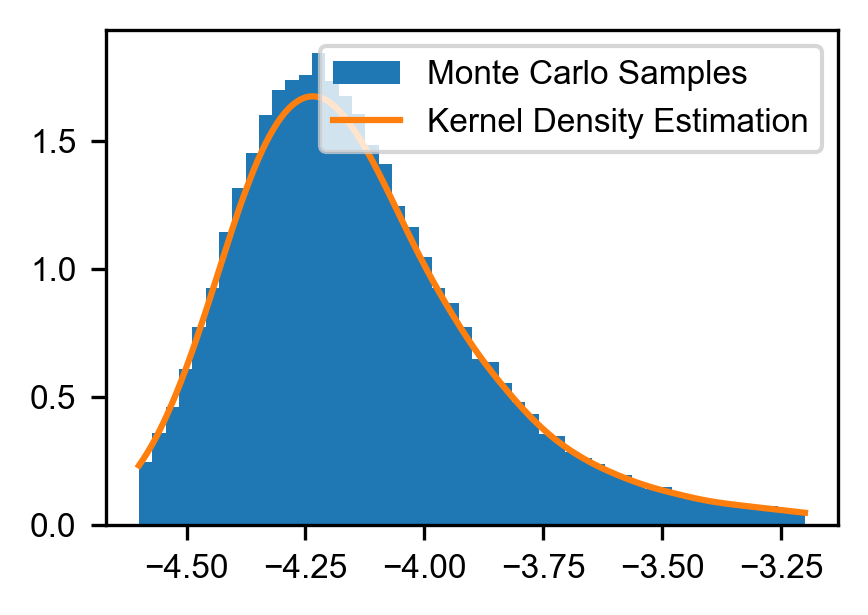

In [12]:
kde_0 = gaussian_kde(np.log(samples_fit.T[0]))
x_kde_0 = np.linspace(-4.6, -3.2, 1000)
y_kde_0 = kde_0(x_kde_0)
plt.hist(np.log(samples_fit.T[0]), bins=50, range=(-4.6, -3.2), density=True, label='Monte Carlo Samples')
plt.plot(x_kde_0, y_kde_0, label='Kernel Density Estimation')
plt.legend()

In [13]:
max_x_0 = x_kde_0[np.argmax(y_kde_0)]
np.e**max_x_0

0.014470609238939211

### KDE of the fits: exponent

In [14]:
data = samples_fit.T[1]
samples_filtered = data[(data > 0.1) & (data < 10.0)]
samples_filtered

array([1.3801432 , 1.78049083, 3.39424982, ..., 2.82452533, 1.59231183,
       1.80537501])

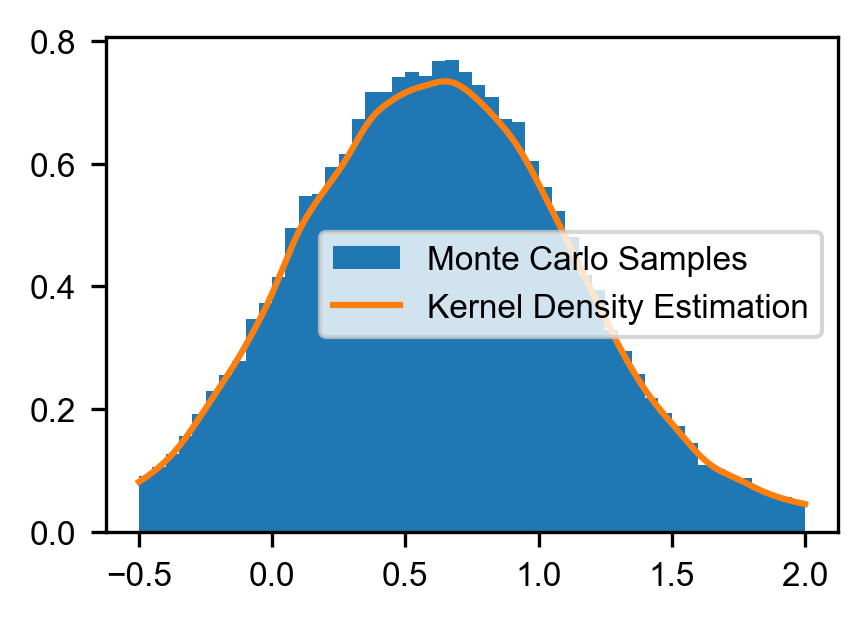

In [15]:
kde_1 = gaussian_kde(np.log(samples_filtered))
x_kde_1 = np.linspace(-0.5, 2.0, 1000)
y_kde_1 = kde_1(x_kde_1)
plt.hist(np.log(samples_filtered), bins=50, range=(-0.5, 2.0), density=True, label='Monte Carlo Samples')
plt.plot(x_kde_1, y_kde_1, label='Kernel Density Estimation')
plt.legend()

In [16]:
max_x_1 = x_kde_1[np.argmax(y_kde_1)]
np.e**max_x_1

1.9129540085713501

In [17]:
np.percentile(samples_filtered, (1+confidence)/2*100)

3.1413650301551566

In [18]:
np.percentile(samples_filtered, (1-confidence)/2*100)

1.0785381537172911